# My year in cycling - polar bar plot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import matplotlib.patches as patches
from matplotlib import font_manager
from datetime import timedelta

from datetime import date, datetime

%matplotlib inline

In [113]:
#load data
df = pd.read_csv("cycling_2021.csv")

#convert date column
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y %H:%M")

#get calendarweeks and month
df["ISOyear"] = df["Date"].dt.isocalendar()["year"]
df["ISOweek"] = df["Date"].dt.isocalendar()["week"]

#get weeks commencing
weeks = df[["ISOyear", "ISOweek"]].drop_duplicates().reset_index(drop=True)
week_commencing = []
for i in range(len(weeks)):
    x = pd.to_datetime(date.fromisocalendar(weeks["ISOyear"][i],weeks["ISOweek"][i],1))
    week_commencing.append(x)   
weeks["week_commencing"] = week_commencing

#merge back to dataframe
df = pd.merge(df, weeks, left_on=["ISOyear", "ISOweek"], right_on=["ISOyear", "ISOweek"], how='left')

# filter to only plot one year (June 2021 to May 2022)
df = df[df["week_commencing"] > pd.to_datetime("2021-05-31")]

In [114]:
#get all Mondays (week commencing) for the interested period (7/6/2021 - 30/5/2022)
end = pd.to_datetime("2022-05-31")
start = pd.to_datetime("2021-06-07")
date_object = start

all_weeks = []
while date_object < pd.to_datetime(end):
    all_weeks.append(date_object)
    date_object += timedelta(days=7)

all_weeks = pd.DataFrame(all_weeks).rename(columns={0:"week_commencing"})

#merge and fill missings
df = pd.merge(df, all_weeks, left_on="week_commencing", right_on="week_commencing", how="outer")
df = df.sort_values(by="week_commencing")
df["Distance"] = df["Distance"].fillna(0)
df.loc[df["Date"].isna(), "Date"] = df["week_commencing"]

#get month based on weeks commencing to group by later
df["month"] = df["week_commencing"].dt.month

In [115]:
#aggregate data by day
df = df.groupby(["week_commencing", "month"])["Distance"].sum().to_frame().reset_index()

#create counts for each week per month
n = 1
week_count = [1]

for i in range(1,len(df)):
    if df["month"][i] == df["month"][i-1]:
        n+=1
        week_count.append(n)
    else:
        n=1
        week_count.append(n)
        
df["week_count"] = week_count

pivot = df.pivot("month", "week_count", "Distance").fillna(0)
pivot

week_count,1,2,3,4,5
month,,,,,
1,45.61,17.13,26.88,20.47,18.91
2,0.00,11.32,41.75,43.84,0.00
3,52.19,48.33,56.60,0.00,0.00
4,31.88,8.90,17.53,57.17,0.00
5,0.00,96.68,134.61,31.70,19.53
6,37.03,0.00,0.00,57.06,0.00
7,62.67,16.88,19.71,30.21,0.00
8,20.42,40.30,71.69,53.68,61.53
9,87.61,65.03,52.67,32.52,0.00


In [63]:
#font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
#set fonts for plots
font_r = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Ubuntu-R.ttf')
font_m = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Ubuntu-M.ttf')
font_b = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Ubuntu-B.ttf')

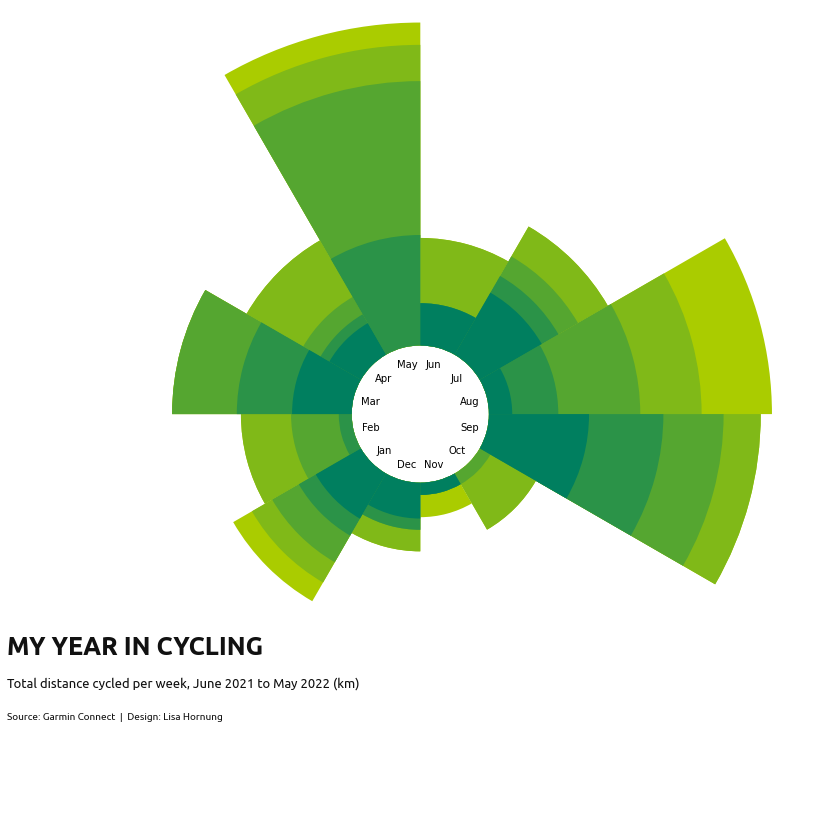

In [134]:
#### data = pivot

# =========
# Initialise Figure and define layout
plt.figure(figsize=(15, 15))
ax = plt.subplot(111, polar=True)

# ============
#data
n_points = 12
inner_radius = 60
bar1 = data[1]
bar2 = data[2] + bar1
bar3 = data[3] + bar2
bar4 = data[4] + bar3
bar5 = data[5] + bar4

x_max = 2*np.pi
x_coords = np.linspace(0, x_max, n_points, endpoint=False)
width = x_max / n_points

#add bars
ax.bar(
    x_coords,
    bar1,
    width=width,
    bottom=inner_radius,
    color="#007f5f",
    alpha=1,
    zorder=5
)

ax.bar(
    x_coords,
    bar2,
    width=width,
    bottom=inner_radius,
    color="#2b9348",
    alpha=1,
    zorder=4
)

ax.bar(
    x_coords,
    bar3,
    width=width,
    bottom=inner_radius,
    color="#55a630",
    alpha=1,
    zorder=3
)

ax.bar(
    x_coords,
    bar4,
    width=width,
    bottom=inner_radius,
    color="#80b918",
    alpha=1,
    zorder=2
)

ax.bar(
    x_coords,
    bar5,
    width=width,
    bottom=inner_radius,
    color="#aacc00",
    alpha=1,
    zorder=1
)

#============
# labels
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec' ]

#add value labels and categories
for i in range(n_points):
    ax.text(x_coords[i], 45, 
            labels[i],
            size=10,
            ha="center", va='center')

#configure theta location and direction
ax.set_theta_zero_location("SW")
ax.set_theta_direction(-1)

ax.axis('off')

# =========
#title and footer
title = "MY YEAR IN CYCLING"
subtitle = "Total distance cycled per week, June 2021 to May 2022 (km)"
x_title=0.13
plt.figtext(x_title,0.28, title, size=25, ha='left',  fontproperties = font_b, color='#111111')
plt.figtext(x_title,0.25, subtitle, size=13,ha='left',  fontproperties = font_r, color='#111111')

plt.figtext(x_title,0.22, "Source: Garmin Connect  |  Design: Lisa Hornung", 
            fontsize=10, ha='left', fontproperties = font_r, color='#111111')

#save
#plt.savefig(os.path.join(root, "outputs//radar-plot.png"), bbox_inches="tight",pad_inches=0.2, transparent=False)

plt.show()